In [1]:
import numpy as np
import matplotlib.pyplot as plt
%cd /home/volkan/Repos/multi-tier
from data_analysis.helpers import *

/home/volkan/.local/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


/home/volkan/Repos/multi-tier


In [2]:
def plotter(
    param_list,
    filters,
    label,
    draw_style,
    test_config,
    topology,
    db,
    metric,
    ax,
    x_variant,
    penalty=False,
):
    param_list = filterParamList(param_list, filters)
    if metric != "penalty":
        res = getDataFieldSumAvgsAcrossSeeds(
            topology,
            db,
            param_list,
            test_config["source_map_seed"],
            test_config["request_generator_seed"],
            metric,
        )
    if penalty or metric == "penalty":
        rpen = getDataFieldSumAvgsAcrossSeeds(
            topology,
            db,
            param_list,
            test_config["source_map_seed"],
            test_config["request_generator_seed"],
            "cache_read_penalties",
        )
        wpen = getDataFieldSumAvgsAcrossSeeds(
            topology,
            db,
            param_list,
            test_config["source_map_seed"],
            test_config["request_generator_seed"],
            "cache_write_penalties",
        )
        if penalty:
            x_variant = np.sum(rpen + wpen, axis=1)
        if metric == "penalty":
            res = np.sum(rpen + wpen, axis=1)

    if isinstance(x_variant[0], (int,float)):
        ax.plot(x_variant, res, draw_style, fillstyle="none", label=label)
    else:
        ax.plot(list(map(str, x_variant)), res, draw_style, fillstyle="none", label=label)


def plotLooper(
    test_config,
    db,
    case_filters,
    ax,
    experiment_name,
    x_label,
    metric,
    topology,
    cache_pols=None,
    curve_label=None,
    legend=None,
    penalty=False,
    x_variant=None,
):
    param_list = simConfigToParamSets(test_config)
    param_list = filterParamList(param_list, case_filters)

    if x_variant is None:
        x_variant = test_config[x_label]
    if isinstance(x_variant[0], list):
        x_variant = list(map(tuple, x_variant))

    if curve_label:
        curve_variant = test_config[curve_label]
        if isinstance(curve_variant[0], list):
            curve_variant = list(map(tuple, curve_variant))
    else:
        curve_variant = []

    if legend is None:
        legend = []
    
    line_styles = {
        "none": "C7",
        "vip": "r^",
        "vipsbw": "b^",
        "vip2": "rv",
        "vipsbw2": "bv",
        "mvip": "rv",
        "palfu": "ks",
        "pawlfu": "k*",
        "lfu": "ks",
        "wlfu": "k*",
        "lru": "gx",
        "fifo": "md",
        "unif": "yo",
    }
    dashes = ["-", "--", ":", "-."]

    if cache_pols is None:
        cache_pols = [pol for pol in test_config["cache_pol"]]

    for cache_pol in cache_pols:
        filters = [("cache_pol", cache_pol, None)]
        if curve_variant:
            filters.append(())
            for i, curve in enumerate(curve_variant):
                label = cache_pol + ", " + curve_label + " " + str(curve)
                legend.append(label)
                filters[1] = (curve_label, curve, None)
                plotter(
                    param_list=param_list,
                    filters=filters,
                    label=label,
                    draw_style=dashes[i] + line_styles[cache_pol],
                    test_config=test_config,
                    topology=topology,
                    db=db,
                    metric=metric,
                    ax=ax,
                    x_variant=x_variant,
                    penalty=penalty,
                )
        else:
            label = cache_pol
            legend.append(label)
            plotter(
                param_list=param_list,
                filters=filters,
                label=label,
                draw_style="-" + line_styles[cache_pol],
                test_config=test_config,
                topology=topology,
                db=db,
                metric=metric,
                ax=ax,
                x_variant=x_variant,
                penalty=penalty,
            )

    ax.set_title(experiment_name + " on " + topology)
    if penalty:
        ax.set_xlabel("penalty")
    else:
        ax.set_xlabel(x_label)
    ax.set_ylabel(metric)
    #ax.ticklabel_format(axis="both", style="sci", scilimits=(0, 0), useMathText=True)
    #ax.legend(legend)
    return legend

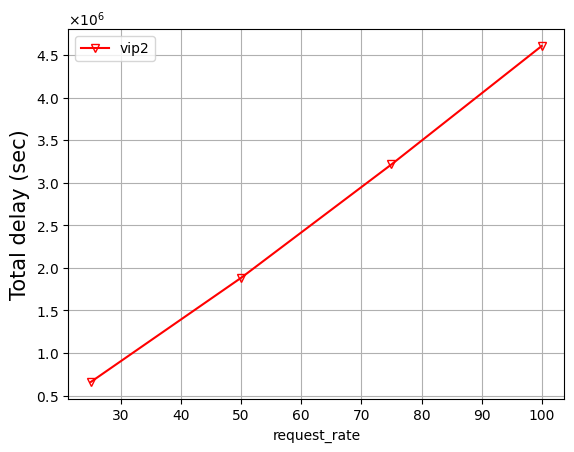

In [30]:
experiment_name = "st_req_ia"
topology = "abilene"
config_path = "sim_configs/" + experiment_name + "_config.json"
#config_path = "sim_configs/sample_config.json"
test_config = getTestConfig(config_path)
db_path = "sim_outputs/" + experiment_name + "_" + topology + "_db.json"
db = getJsonDb(db_path)

request_dist_param = 0.5
request_rate = 15
request_dist_type = "zipf"
case_filters = [
    #("cache_capacities", [(10,)], None),
    #("cache_read_rates", [(25,), (25, 10)], None),
    #("request_dist_param", request_dist_param, None),
    #("request_dist_type", request_dist_type, None),
    #("request_rate", request_rate, None),
    #("vip_win_size", 100, None),
    #("num_objects", 2000, None),
    #("cache_read_pens", (2,1), None),
    #("vip_inc", 2, None),
    #("vip_slot_len", 4, None),
    ("vip_ia_coeff", 0.125, None),
    ("vip_ia_factor", 1.0, None),
]
metric="delay"
fig, ax = plt.subplots()
leg = plotLooper(
    test_config=test_config,
    db=db,
    case_filters=case_filters,
    ax=ax,
    experiment_name=experiment_name,
    #x_label="cache_capacities",
    x_label="request_rate",
    metric=metric,
    topology=topology,
    #curve_label="cache_capacities",
    #curve_label="vip_ia_factor",
    penalty=False,
    #cache_pols=["mvip"],
    #x_variant=[[5],[6],[7],[8],[9],[10]],
)
ax.legend(leg)
#ax.legend(["LFU", "LRU", "UNIF", "FIFO", "MVIP"],fontsize=11,bbox_to_anchor=(0.95, 0.6))
#ax.legend(["LFU", "MVIP"],fontsize=12)
ax.set_title("")
if metric == "delay":
    ax.set_ylabel("Total delay (sec)",fontsize=15)
if metric == "cache_replacements":
    ax.set_ylabel("Total cache replacements",fontsize=15)
#ax.set_xlabel("Cache capacities ($L_{n_1}$,$L_{n_2}$)",fontsize=14)
#title = ax.set_title(ax.get_title() + " $\lambda$=" + str(request_rate) + " $\\alpha$=" + str(request_dist_param))
ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0), useMathText=True)
fig_name = "_".join(tuple(map(str,(experiment_name,topology,request_rate,request_dist_type,request_dist_param,metric))))
fig_path = "../sim_outputs/" + fig_name + ".pdf"
#fig.savefig(fig_path)
ax.grid()
plt.show()

In [ ]:
experiment_name = "vip"
topology = "grid"
config_path = "../sim_configs/" + experiment_name + "_config.json"
test_config = getTestConfig(config_path)
db_path = "../sim_outputs/" + experiment_name + "_" + topology + "_db.json"
db = getJsonDb(db_path)

request_dist_param = 0.75
request_rate = 15
request_dist_type = "shuffle_zipf"
case_filters = [
    #("cache_capacities", (5,100), None),
    #("cache_read_rates", [(25,), (25, 10)], None),
    ("request_dist_param", request_dist_param, None),
    #("request_dist_type", request_dist_type, None),
    #("request_rate", request_rate, None),
    #("vip_win_size", 100, None),
    #("num_objects", 1000, None)
    #("cache_read_pens", (2,1), None),
    #("vip_inc", 5, None),
    ("vip_slot_len", 4, None),
]
metric="delay"
fig, ax = plt.subplots()
leg = plotLooper(
    test_config=test_config,
    db=db,
    case_filters=case_filters,
    ax=ax,
    experiment_name=experiment_name,
    #x_label="cache_capacities",
    x_label="pen_weight",
    metric=metric,
    topology=topology,
    curve_label="cache_capacities",
    penalty=True,
    #cache_pols=["vip2"],
    #x_variant=[[5],[6],[7],[8],[9],[10]],
)
ax.legend(leg)
#ax.legend(["LFU", "LRU", "UNIF", "FIFO", "MVIP"],fontsize=11,bbox_to_anchor=(0.95, 0.6))
#ax.legend(["LFU", "MVIP"],fontsize=12)
ax.set_title("")
if metric == "delay":
    ax.set_ylabel("Total delay (sec)",fontsize=15)
if metric == "cache_replacements":
    ax.set_ylabel("Total cache replacements",fontsize=15)
#ax.set_xlabel("Cache capacities ($L_{n_1}$,$L_{n_2}$)",fontsize=14)
#title = ax.set_title(ax.get_title() + " $\lambda$=" + str(request_rate) + " $\\alpha$=" + str(request_dist_param))
ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0), useMathText=True)
fig_name = "_".join(tuple(map(str,(experiment_name,topology,request_rate,request_dist_type,request_dist_param,metric))))
fig_path = "../sim_outputs/" + fig_name + ".pdf"
#fig.savefig(fig_path)
ax.grid()
plt.show()


In [ ]:
lrt_none_filters = case_filters + [("cache_pol", "none", None), ("fwd_pol", "lrt", None)]
vip_none_filters = case_filters + [("cache_pol", "none", None), ("fwd_pol", "vip", None)]
lrt_none_params = simConfigToParamSets(test_config)
lrt_none_params = filterParamList(lrt_none_params, lrt_none_filters)
lrt_none_delay = getDataFieldSumAvgsAcrossSeeds(topology, db, lrt_none_params, test_config["source_map_seed"], test_config["request_generator_seed"], "delay")
print(lrt_none_delay)
vip_none_params = simConfigToParamSets(test_config)
vip_none_params = filterParamList(vip_none_params, vip_none_filters)
vip_none_delay = getDataFieldSumAvgsAcrossSeeds(topology, db, vip_none_params, test_config["source_map_seed"], test_config["request_generator_seed"], "delay")
print(vip_none_delay)